# Contrastive Learning

Reference: https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial17/SimCLR.html

<style>
p {
    line-height: 1.8; /* 设置行距为 1.8，这个值可以根据需要调整 */

}
</style>

在這個教程中，我們將深入探討自監督對比學習（Self-supervised contrastive learning）。自監督學習（Self-supervised learning），有時也稱為無監督學習（Unsupervised learning），是指在沒有標籤的情況下，我們依然可以從輸入數據中學習。雖然這些數據沒有提供有監督學習所需的標籤，但仍然包含了大量有價值的資訊。例如，我們可以學到圖像之間的差異、某些圖像的特徵模式，或是嘗試對圖像進行聚類等。自監督學習的目標是在僅依賴數據本身的情況下，最大化學習效果，這樣就可以快速微調模型以應對具體的分類任務。自監督學習的一個優勢是，通常很容易獲取大量數據。例如，若我們想訓練一個用於自動駕駛的視覺模型進行語義分割（Semantic segmentation），只需在車上安裝攝像頭並在城市中駕駛一小時，即可收集大量數據。相比之下，若是使用有監督學習，我們必須手動標註這些圖像，這不僅成本高昂，還可能需要數月時間才能完成標註。此外，自監督學習也為從 ImageNet 預訓練模型進行遷移學習提供了另一種選擇，因為我們可以直接針對特定數據集或場景（如自動駕駛的交通場景）來預訓練模型。

過去兩年來，特別針對圖像領域，許多自監督學習的新方法相繼被提出，並且在標籤有限的情況下，已經超越了有監督學習模型的表現。在本教程中，我們將重點介紹對比學習（Contrastive learning）。對比學習的核心在於探討圖像之間的差異。具體而言，對比學習方法訓練模型，在潛在空間中將一張圖像與其增強版進行聚類，並最大化與其他圖像之間的距離。最近出現的一個簡單且新穎的對比學習方法是 SimCLR，該方法的視覺化如下（圖片來源：Ting Chen 等人）。

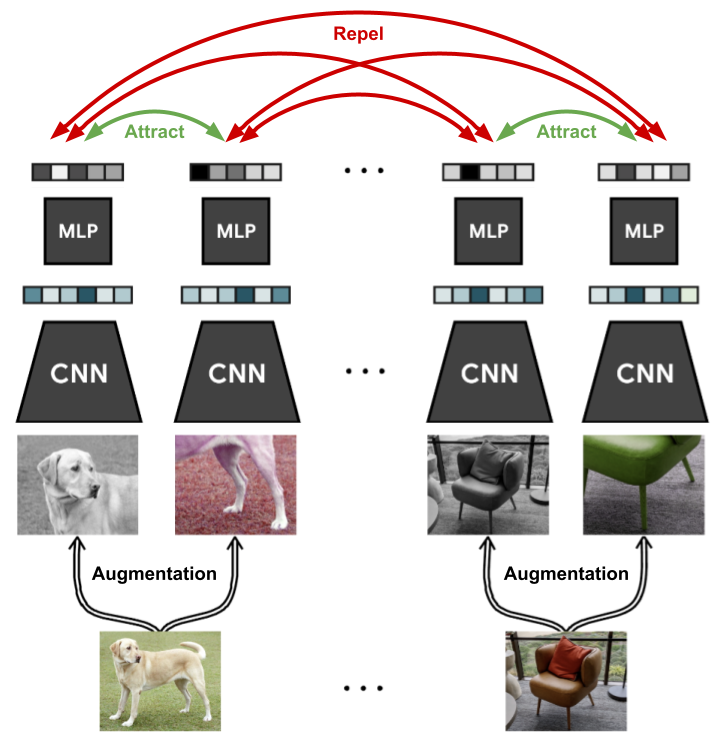

一般的設置是，我們擁有一個沒有標籤的圖像數據集，目的是訓練一個模型，讓它能夠在未來快速適應任何圖像識別任務。每次訓練迭代中，我們會從數據集中抽取一批圖像。對於每張圖像，我們通過使用數據增強技術（如裁剪、高斯噪聲、模糊等）生成兩個不同的版本。左邊狗的圖像是一個示例。我們稍後會詳細討論這些增強技術的選擇和效果。然後，我們對這些圖像使用 ResNet 這類 CNN（卷積神經網絡），得到一個 1D 的特徵向量，接著應用一個小型 MLP（多層感知機）。這兩張增強後圖像的輸出特徵會被訓練成彼此接近，而該批次中的其他圖像則應該保持盡可能不同。通過這種方式，模型必須學習那些在數據增強過程中保持不變的圖像內容，例如我們在有監督任務中通常關心的物體。

現在，我們將親自實現這個框架，並在過程中討論更多細節。首先，我們來導入以下的標準庫：

In [1]:
## Standard libraries
import os
from copy import deepcopy

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import STL10
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Import tensorboard
%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial17"
# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = os.cpu_count()

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

/tmp/ipykernel_213321/2552854368.py:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
Seed set to 42


Device: cuda:0
Number of workers: 20


<Figure size 640x480 with 0 Axes>

<style>
p {
    line-height: 1.8; /* 设置行距为 1.8，这个值可以根据需要调整 */

}
</style>

如同之前的許多教程，我們這次也提供了預訓練模型。請注意，由於我們使用的是預設的 ResNet-18 架構，這些模型的大小會比通常稍大一些（總共大約 100MB）。如果你在本地運行這個筆記本，請確保你的磁碟有足夠的空間。

In [2]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial17/"
# Files to download
pretrained_files = ["SimCLR.ckpt", "ResNet.ckpt",
                    "tensorboards/SimCLR/events.out.tfevents.SimCLR",
                    "tensorboards/classification/ResNet/events.out.tfevents.ResNet"]
pretrained_files += [f"LogisticRegression_{size}.ckpt" for size in [10, 20, 50, 100, 200, 500]]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

<style>
p {
    line-height: 1.8; /* 设置行距为 1.8，这个值可以根据需要调整 */
}
</style>


## SimCLR
我們將從探討對比學習中的不同數據增強技術開始，並了解如何為此構建高效的數據加載器。接著，我們會用 PyTorch Lightning 實現 SimCLR，並最終在一個大型無標籤數據集上進行訓練。

對比學習的數據增強
為了實現高效的訓練，我們需要設置數據加載過程，以便在批次中對每張圖像進行兩次不同的隨機增強。最簡單的方法是創建一個轉換函數，當被調用時，對同一張圖像應用一組數據增強兩次。這在下面的 `ContrastiveTransformations` 類中實現：

In [3]:
class ContrastiveTransformations(object):

    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]

<style>
p {
    line-height: 1.8; /* 设置行距为 1.8，这个值可以根据需要调整 */
}
</style>
對比學習框架可以通過對同一張圖像採樣多於兩個的增強版本來擴展正樣本數量。然而，通常最有效的訓練方式是僅使用兩個增強版本。

接下來，我們來看一下具體的數據增強技術。增強技術的選擇是 SimCLR 中最關鍵的超參數，因為它直接影響潛在空間的結構，並決定模型從數據中能學習到哪些模式。首先，讓我們來看看一些最常用的數據增強技術（圖片來源：Ting Chen 和 Geoffrey Hinton）。

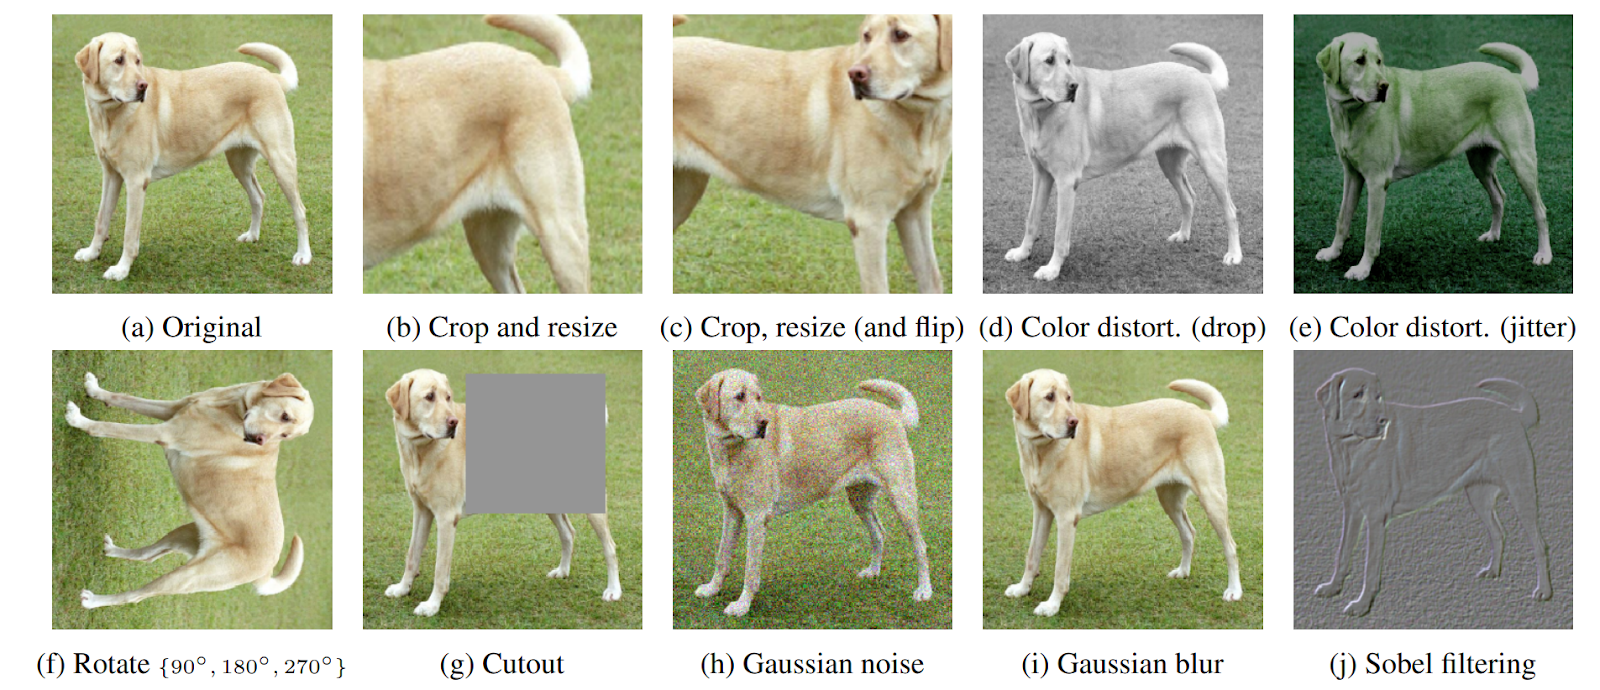

所有的增強技術都可以使用，但研究顯示有兩種增強技術特別重要：裁剪與縮放（crop-and-resize）以及顏色扭曲（color distortion）。有趣的是，正如 Ting Chen 等人在 SimCLR 論文中所討論的那樣，只有這兩種技術結合使用時，才能顯著提升效能。在進行隨機裁剪和縮放時，我們可以區分兩種情況：(a) 裁剪後的圖像 A 提供了裁剪圖像 B 的局部視角，或 (b) 裁剪圖像 C 和 D 顯示的是同一圖像的相鄰視角（圖片來源：Ting Chen 和 Geoffrey Hinton）。

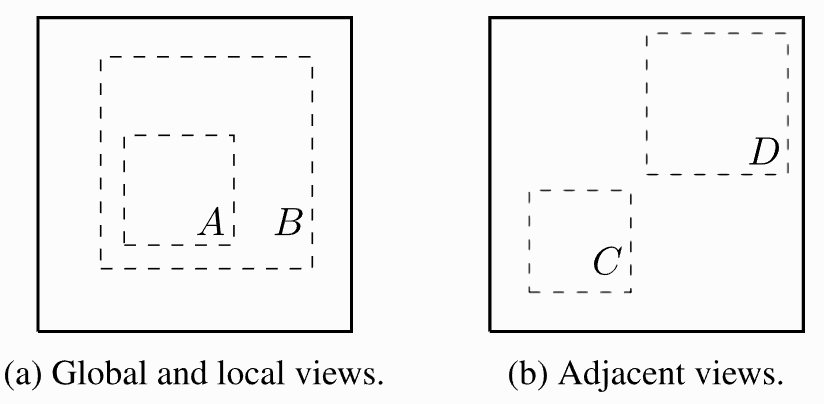

情況 (a) 需要模型學習某種尺度不變性，使裁剪後的 A 和 B 在潛在空間中相似；而情況 (b) 則更具挑戰，因為模型需要在有限的視野下識別物體。如果不進行顏色扭曲，模型可能會利用一個漏洞，即同一圖像的不同裁剪通常在色彩空間中非常相似。以狗的圖片為例，僅透過毛皮的顏色和背景的綠色色調，你可以推斷兩個區塊屬於同一張圖片，而不需要真正識別圖中的狗。在這種情況下，模型可能會只關注圖像的色彩直方圖，而忽略其他更具有泛化性的特徵。但如果我們對這兩個區塊進行隨機且獨立的顏色扭曲，模型將無法再依賴這一簡單特徵。因此，通過結合隨機裁剪和顏色扭曲，模型只能透過學習可泛化的表示來正確匹配這兩個區塊。

在我們的實驗中，我們遵循了原始的 SimCLR 設置，使用了五種轉換：隨機水平翻轉、裁剪與縮放、顏色扭曲、隨機灰階和高斯模糊。與原始設置相比，我們稍微減弱了顏色抖動的效果（亮度、對比度和飽和度設定為 0.5，而非 0.8；色調設定為 0.1，而非 0.2）。在我們的實驗中，這樣的設定不僅效果更好，訓練速度更快且更穩定。如果某個資料集的亮度變化幅度很大，則原始設定可能會更有幫助，因為模型將無法再依賴亮度來區分圖像。

In [4]:
contrast_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                          transforms.RandomResizedCrop(size=96),
                                          transforms.RandomApply([
                                              transforms.ColorJitter(brightness=0.5,
                                                                     contrast=0.5,
                                                                     saturation=0.5,
                                                                     hue=0.1)
                                          ], p=0.8),
                                          transforms.RandomGrayscale(p=0.2),
                                          transforms.GaussianBlur(kernel_size=9),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5,), (0.5,))
                                         ])

<style>
p {
    line-height: 1.8; /* 设置行距为 1.8，这个值可以根据需要调整 */
}
</style>
在討論完數據增強技術後，我們現在可以將重點放在數據集上。在這個教程中，我們將使用 STL10 數據集。該數據集與 CIFAR10 類似，包含 10 個類別的圖像：飛機、鳥、汽車、貓、鹿、狗、馬、猴子、船和卡車。然而，STL10 的圖像解析度更高，為 96 × 96 像素，每個類別有 500 張標記的圖像。此外，我們還擁有一個包含 100,000 張無標籤圖像的大型數據集，這些圖像與訓練圖像相似，但來自更多種類的動物和車輛。這使得 STL10 非常適合作為展示自監督學習優勢的理想數據集。

STL10 數據集是通過 torchvision 提供的。不過需要注意的是，這個數據集比 CIFAR10 大得多，解析度也高很多，因此需要更多的磁碟空間（約 3GB），下載時間也會相對較長。在我們對自監督學習與 SimCLR 的討論中，我們將使用對比轉換技術來創建兩個數據加載器：`unlabeled_data` 將用於通過對比學習進行模型訓練，而 `train_data_contrast` 將作為對比學習的驗證集。

In [5]:
unlabeled_data = STL10(root=DATASET_PATH, split='unlabeled', download=True,
                       transform=ContrastiveTransformations(contrast_transforms, n_views=2))
train_data_contrast = STL10(root=DATASET_PATH, split='train', download=True,
                            transform=ContrastiveTransformations(contrast_transforms, n_views=2))

100%|██████████| 2640397119/2640397119 [1:37:04<00:00, 453360.01it/s]  


Extracting ../data/stl10_binary.tar.gz to ../data
Files already downloaded and verified


最後，在我們開始實作 SimCLR 之前，先來看看一些應用增強技術後的圖像對範例：

Seed set to 42


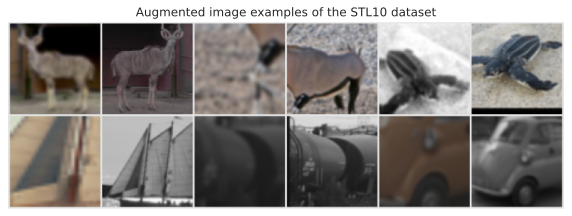

In [7]:
# Visualize some examples
pl.seed_everything(42)
NUM_IMAGES = 6
imgs = torch.stack([img for idx in range(NUM_IMAGES) for img in unlabeled_data[idx][0]], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(10,5))
plt.title('Augmented image examples of the STL10 dataset')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

<style>
p {
    line-height: 1.8; /* 设置行距为 1.8，这个值可以根据需要调整 */
}
</style>
我們可以看到各種數據增強技術的多樣性，包括隨機裁剪、灰階處理、高斯模糊和顏色扭曲。因此，讓模型能夠匹配兩個經過獨立增強的同一張圖像的區塊，仍然是一個具有挑戰性的任務。

<style>
p {
    line-height: 1.8; /* 设置行距为 1.8，这个值可以根据需要调整 */
}
</style>


## SimCLR 實作

基於上面所提到的數據加載器管道，我們現在可以開始實作 SimCLR。在每次訓練迭代中，我們會對每張圖像 $x$ 生成兩個不同的增強版本，分別記作 $\tilde{x}_i$ 和 $\tilde{x}_j$。這兩張圖像會被編碼為一維特徵向量，我們希望最大化它們之間的相似性，同時最小化它們與批次中其他圖像的相似性。編碼器網絡由兩個部分組成：基礎編碼網絡 $f(\cdot)$ 和投影頭 $g(\cdot)$。基礎網絡通常是一個深度 CNN，例如我們在之前的教程（如教程 5）中介紹的，用來從增強後的數據中提取表示向量。在我們的實驗中，我們將使用常見的 ResNet-18 架構作為 $f(\cdot)$，並將輸出記作 $f(\tilde{x}_i) = h_i$。投影頭 $g(\cdot)$ 會將表示向量 $h$ 映射到一個空間，然後我們在該空間中應用對比損失，用來比較向量之間的相似性。

這通常被設置為一個小型 MLP（多層感知機），並帶有非線性功能。為了簡化，我們遵循原始 SimCLR 論文的設定，將其定義為一個具有 ReLU 激活功能的兩層 MLP。需要注意的是，在後續的 SimCLRv2 論文中，作者提到更大或更寬的 MLP 可以大幅提升性能。因此，我們使用了一個隱藏維度為四倍的 MLP，但發現更深的 MLP 在我們使用的數據集上會導致過擬合。以下圖表展示了整體架構（圖片來源：Ting Chen 等人）：

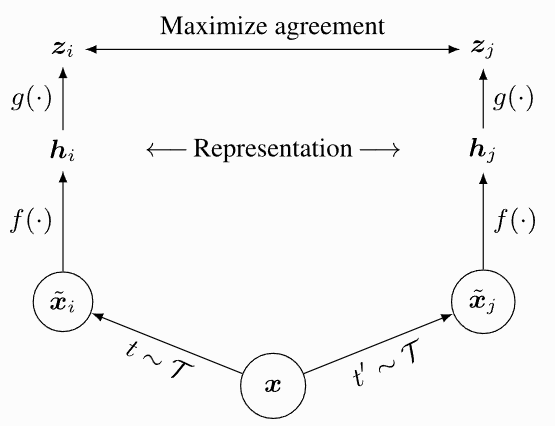


在完成對比學習訓練後，我們會移除投影頭 $g(\cdot)$，並將 $f(\cdot)$ 用作預訓練的特徵提取器。研究表明，來自投影頭 $g(\cdot)$ 的表示 $z$ 在微調模型應用於新任務時，性能不如基礎網絡 $f(\cdot)$ 的表現。這可能是因為 $z$ 被訓練成對許多特徵（如顏色）不敏感，而這些特徵對後續任務可能非常重要。因此，$g(\cdot)$ 僅在對比學習階段中起作用。

現在我們已經介紹了架構，接下來我們來深入了解如何訓練模型。正如之前所提到的，我們希望最大化同一張圖像的兩個增強版本之間的表示相似性，即 $z_i$ 和 $z_j$，同時將它們與批次中其他圖像的相似性最小化。SimCLR 採用了 InfoNCE 損失函數，這最初是由 Aaron van den Oord 等人提出的，用於對比學習。簡單來說，InfoNCE 損失會比較 $z_i$ 和 $z_j$ 之間的相似性，並將它與批次中其他圖像的相似性進行比較，透過 softmax 來計算相似性值。該損失函數可以寫成如下公式：

$$
\ell_{i,j} = -\log \frac{\exp(\text{sim}(z_i, z_j)/\tau)}{\sum_{k=1}^{2N}\mathbb{1}_{[k \neq i]} \exp(\text{sim}(z_i, z_k)/\tau)} = -\frac{\text{sim}(z_i, z_j)}{\tau} + \log\left[\sum_{k=1}^{2N} \mathbb{1}_{[k \neq i]} \exp(\frac{\text{sim}(z_i, z_k)}{\tau})\right]
$$


函數 $\text{sim}$ 是一個相似性度量，而超參數 $\tau$ 稱為溫度，決定了分佈的尖銳程度。由於許多相似性度量都有邊界，溫度參數可以幫助我們平衡許多不相似的圖像區塊與某個相似區塊之間的影響。在 SimCLR 中，我們使用餘弦相似度作為相似性度量，定義如下：


$$
\text{sim}(z_i, z_j) = \frac{z_i^\top \cdot z_j}{\|z_i\| \cdot \|z_j\|}
$$


餘弦相似度的最大值是 1，最小值是 -1。通常，我們會發現來自不同圖像的特徵會收斂到接近 0 的餘弦相似度，因為最小值 -1 代表 $z_i$ 和 $z_j$ 在所有特徵維度上完全相反，這樣的情況不常發生，且會限制模型的靈活性。

現在，我們已經討論了所有細節，接下來讓我們用 PyTorch Lightning 模組來實作 SimCLR。








In [8]:
class SimCLR(pl.LightningModule):

    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'
        # Base model f(.)
        self.convnet = torchvision.models.resnet18(num_classes=4*hidden_dim)  # Output of last linear layer
        # The MLP for g(.) consists of Linear->ReLU->Linear
        self.convnet.fc = nn.Sequential(
            self.convnet.fc,  # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim, hidden_dim)
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                            T_max=self.hparams.max_epochs,
                                                            eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode='train'):
        imgs, _ = batch
        imgs = torch.cat(imgs, dim=0)

        # Encode all images
        feats = self.convnet(imgs)
        # Calculate cosine similarity
        cos_sim = F.cosine_similarity(feats[:,None,:], feats[None,:,:], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode+'_loss', nll)
        # Get ranking position of positive example
        comb_sim = torch.cat([cos_sim[pos_mask][:,None],  # First position positive example
                              cos_sim.masked_fill(pos_mask, -9e15)],
                             dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode+'_acc_top1', (sim_argsort == 0).float().mean())
        self.log(mode+'_acc_top5', (sim_argsort < 5).float().mean())
        self.log(mode+'_acc_mean_pos', 1+sim_argsort.float().mean())

        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')

<style>
p {
    line-height: 1.8; /* 设置行距为 1.8，这个值可以根据需要调整 */
}
</style>

除了對比學習（contrastive learning）損失進行驗證之外，我們還可以選擇一個簡單的小型下游任務，並跟踪基礎網絡 $ f(\cdot) $ 在該任務上的表現。然而，在本教程中，我們將僅限於 STL10 數據集，並以圖像分類作為 STL10 的測試任務。

### 訓練

現在我們已經實現了 SimCLR 並設置好了數據加載管道，我們已經準備好進行模型訓練。我們將使用與往常相同的訓練功能設置。為了保存最佳模型檢查點，我們將跟踪指標 $\text{val\_acc\_top5}$，該指標描述了正確的圖像片段在批次中最相似的前五個示例中的頻率。這個指標通常比 top-1 指標的波動性更小，因此成為選擇最佳模型時更合適的標準。

In [9]:
def train_simclr(batch_size, max_epochs=500, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, 'SimCLR'),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc_top5'),
                                    LearningRateMonitor('epoch')])
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, 'SimCLR.ckpt')
    if os.path.isfile(pretrained_filename):
        print(f'Found pretrained model at {pretrained_filename}, loading...')
        model = SimCLR.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        train_loader = data.DataLoader(unlabeled_data, batch_size=batch_size, shuffle=True,
                                       drop_last=True, pin_memory=True, num_workers=NUM_WORKERS)
        val_loader = data.DataLoader(train_data_contrast, batch_size=batch_size, shuffle=False,
                                     drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)
        pl.seed_everything(42) # To be reproducable
        model = SimCLR(max_epochs=max_epochs, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    return model

<style>
p {
    line-height: 1.8; /* 设置行距为 1.8，这个值可以根据需要调整 */
}
</style>

在對比學習（contrastive learning）中，一個常見的觀察是，批次大小越大，模型的表現越好。較大的批次大小可以讓我們將每張圖像與更多的負樣本進行比較，從而使損失梯度更加平滑。不過，在我們的實驗中，批次大小為 256 已經足夠產生不錯的結果。

In [10]:
simclr_model = train_simclr(batch_size=256,
                            hidden_dim=128,
                            lr=5e-4,
                            temperature=0.07,
                            weight_decay=1e-4,
                            max_epochs=500)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../saved_models/tutorial17/SimCLR.ckpt`


Found pretrained model at ../saved_models/tutorial17/SimCLR.ckpt, loading...


為了更直觀地了解對比學習（contrastive learning）的訓練過程，我們可以查看下方的 TensorBoard。

In [ ]:
%tensorboard --logdir ../saved_models/tutorial17/tensorboards/SimCLR/

<style>
p {
    line-height: 1.8; /* 设置行距为 1.8，这个值可以根据需要调整 */
}
</style>

值得注意的是，對比學習（contrastive learning）在長時間訓練中受益頗多。上方圖表顯示的結果來自一次約為 1 天的訓練，使用了 NVIDIA TitanRTX。如果進行更長時間的訓練，可能會進一步降低損失值，但我們在圖像分類的下游任務中並未因此獲得額外的效益。一般來說，若有足夠的無標籤數據，對比學習也能從使用更大規模的模型中獲得好處。

<style>
p {
    line-height: 1.8; /* 设置行距为 1.8，这个值可以根据需要调整 */
}
</style>

## Logistic Regression

在我們通過對比學習（contrastive learning）訓練完模型後，我們可以將其應用於下游任務，並觀察它在少量數據下的表現。一種常見的設定是進行邏輯回歸（Logistic Regression），這也能驗證模型是否學到了通用的表示。換句話說，我們學習了一個單一的線性層，將表示映射到類別預測。由於基礎網絡 $f(\cdot)$ 在訓練過程中不會發生改變，模型僅在 $h$ 的表示能夠描述完成任務所需的所有特徵時才能表現良好。此外，由於我們訓練的參數非常少，因此不必過度擔心過擬合。因此，我們可以期待模型即使在極少數據的情況下也能表現良好。

首先，我們來實現一個簡單的邏輯回歸（Logistic Regression）設置，假設圖像已經被編碼為它們的特徵向量。如果可用的數據非常少，我們可以動態地在訓練過程中對圖像進行編碼，並應用數據增強。然而，這裡的實現方式更加高效，並且可以在幾秒鐘內完成訓練。此外，在這個簡單的設置中，使用數據增強並沒有顯示出顯著的提升效果。



In [13]:
class LogisticRegression(pl.LightningModule):

    def __init__(self, feature_dim, num_classes, lr, weight_decay, max_epochs=100):
        super().__init__()
        self.save_hyperparameters()
        # Mapping from representation h to classes
        self.model = nn.Linear(feature_dim, num_classes)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                                      milestones=[int(self.hparams.max_epochs*0.6),
                                                                  int(self.hparams.max_epochs*0.8)],
                                                      gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode='train'):
        feats, labels = batch
        preds = self.model(feats)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(mode + '_loss', loss)
        self.log(mode + '_acc', acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='val')

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='test')

我們使用的數據集是 STL10 的訓練集和測試集。訓練集中每個類別包含 500 張圖像，而測試集中每個類別有 800 張圖像。

In [14]:
img_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5,), (0.5,))])

train_img_data = STL10(root=DATASET_PATH, split='train', download=True,
                       transform=img_transforms)
test_img_data = STL10(root=DATASET_PATH, split='test', download=True,
                      transform=img_transforms)

print("Number of training examples:", len(train_img_data))
print("Number of test examples:", len(test_img_data))

Files already downloaded and verified
Files already downloaded and verified
Number of training examples: 5000
Number of test examples: 8000


<style>
p {
    line-height: 1.8; /* 设置行距为 1.8，这个值可以根据需要调整 */
}
</style>

接下來，我們實現了一個小函數來編碼數據集中所有的圖像。生成的表示將作為邏輯回歸（Logistic Regression）模型的輸入。

In [15]:
@torch.no_grad()
def prepare_data_features(model, dataset):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    data_loader = data.DataLoader(dataset, batch_size=64, num_workers=NUM_WORKERS, shuffle=False, drop_last=False)
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(data_loader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)

    # Sort images by labels
    labels, idxs = labels.sort()
    feats = feats[idxs]

    return data.TensorDataset(feats, labels)

讓我們將該函數應用於訓練集和測試集。

In [16]:
train_feats_simclr = prepare_data_features(simclr_model, train_img_data)
test_feats_simclr = prepare_data_features(simclr_model, test_img_data)

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

<style>
p {
    line-height: 1.8; /* 设置行距为 1.8，这个值可以根据需要调整 */
}
</style>

最後，我們可以像往常一樣撰寫一個訓練函數。我們每 10 個 epoch 對測試集進行一次評估，以便及早停止訓練，但較低的驗證頻率確保我們不會在測試集上過度擬合。

In [17]:
def train_logreg(batch_size, train_feats_data, test_feats_data, model_suffix, max_epochs=100, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "LogisticRegression"),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc'),
                                    LearningRateMonitor("epoch")],
                         enable_progress_bar=False,
                         check_val_every_n_epoch=10)
    trainer.logger._default_hp_metric = None

    # Data loaders
    train_loader = data.DataLoader(train_feats_data, batch_size=batch_size, shuffle=True,
                                   drop_last=False, pin_memory=True, num_workers=0)
    test_loader = data.DataLoader(test_feats_data, batch_size=batch_size, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=0)

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"LogisticRegression_{model_suffix}.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = LogisticRegression.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)  # To be reproducable
        model = LogisticRegression(**kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = LogisticRegression.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on train and validation set
    train_result = trainer.test(model, train_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"train": train_result[0]["test_acc"], "test": test_result[0]["test_acc"]}

    return model, result

<style>
p {
    line-height: 1.8; /* 设置行距为 1.8，这个值可以根据需要调整 */
}
</style>

儘管 STL10 的訓練集每個類別已經只有 500 張帶標籤的圖像，但我們將在更小的數據集上進行實驗。具體來說，我們將為每個類別訓練一個邏輯回歸模型，數據集包含 10、20、50、100、200 和所有 500 個樣本。這可以讓我們直觀了解，對比學習（contrastive learning）所學到的表示能在像這樣的圖像分類任務中轉移得多好。首先，我們來定義一個函數，從完整的訓練集中創建所需的子數據集：

In [18]:
def get_smaller_dataset(original_dataset, num_imgs_per_label):
    new_dataset = data.TensorDataset(
        *[t.unflatten(0, (10, -1))[:,:num_imgs_per_label].flatten(0, 1) for t in original_dataset.tensors]
    )
    return new_dataset

<style>
p {
    line-height: 1.8; /* 设置行距为 1.8，这个值可以根据需要调整 */
}
</style>

接下來，讓我們運行所有模型。即便我們要訓練 6 個模型，這段程式碼仍然可以在一到兩分鐘內完成運行，甚至不需要預訓練模型。

In [20]:
results = {}
for num_imgs_per_label in [10, 20, 50, 100, 200, 500]:
    sub_train_set = get_smaller_dataset(train_feats_simclr, num_imgs_per_label)
    _, small_set_results = train_logreg(batch_size=64,
                                        train_feats_data=sub_train_set,
                                        test_feats_data=test_feats_simclr,
                                        model_suffix=num_imgs_per_label,
                                        feature_dim=train_feats_simclr.tensors[0].shape[1],
                                        num_classes=10,
                                        lr=1e-3,
                                        weight_decay=1e-3)
    results[num_imgs_per_label] = small_set_results

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../saved_models/tutorial17/LogisticRegression_10.ckpt`
You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2024-09-25 14:24:59.662836: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered


Found pretrained model at ../saved_models/tutorial17/LogisticRegression_10.ckpt, loading...


2024-09-25 14:24:59.672386: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-25 14:24:59.675131: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-25 14:24:59.681884: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-25 14:25:00.344055: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/cosmo/anaconda3/envs/pytorch231_cuda121_python310/lib/python3.10/site-packages/pytorch_ligh

Found pretrained model at ../saved_models/tutorial17/LogisticRegression_20.ckpt, loading...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../saved_models/tutorial17/LogisticRegression_50.ckpt`
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Found pretrained model at ../saved_models/tutorial17/LogisticRegression_50.ckpt, loading...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../saved_models/tutorial17/LogisticRegression_100.ckpt`
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Found pretrained model at ../saved_models/tutorial17/LogisticRegression_100.ckpt, loading...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../saved_models/tutorial17/LogisticRegression_200.ckpt`
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Found pretrained model at ../saved_models/tutorial17/LogisticRegression_200.ckpt, loading...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../saved_models/tutorial17/LogisticRegression_500.ckpt`
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Found pretrained model at ../saved_models/tutorial17/LogisticRegression_500.ckpt, loading...


最後，讓我們繪製結果圖。

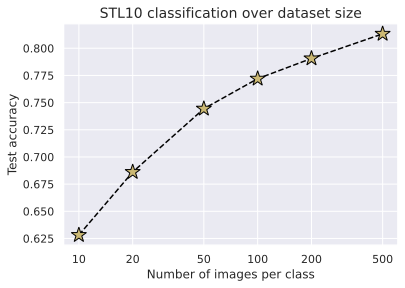

Test accuracy for  10 images per label: 62.81%
Test accuracy for  20 images per label: 68.61%
Test accuracy for  50 images per label: 74.44%
Test accuracy for 100 images per label: 77.20%
Test accuracy for 200 images per label: 79.06%
Test accuracy for 500 images per label: 81.33%


In [21]:
dataset_sizes = sorted([k for k in results])
test_scores = [results[k]["test"] for k in dataset_sizes]

fig = plt.figure(figsize=(6,4))
plt.plot(dataset_sizes, test_scores, '--', color="#000", marker="*", markeredgecolor="#000", markerfacecolor="y", markersize=16)
plt.xscale("log")
plt.xticks(dataset_sizes, labels=dataset_sizes)
plt.title("STL10 classification over dataset size", fontsize=14)
plt.xlabel("Number of images per class")
plt.ylabel("Test accuracy")
plt.minorticks_off()
plt.show()

for k, score in zip(dataset_sizes, test_scores):
    print(f'Test accuracy for {k:3d} images per label: {100*score:4.2f}%')

<style>
p {
    line-height: 1.8; /* 设置行距为 1.8，这个值可以根据需要调整 */
}
</style>

正如預期的一樣，隨著數據量的增加，分類性能會有所提升。然而，即使每個類別僅有 10 張圖像，我們已經能夠正確分類超過 60% 的圖像。這相當令人印象深刻，尤其考慮到這些圖像的維度比 CIFAR10 還要高。使用完整數據集時，我們達到了 81% 的準確率。從每個類別 50 張圖像增加到 500 張圖像的過程中，可能顯示出隨著數據集指數增長，性能呈線性提升的趨勢。然而，如果我們擁有更多數據，也可以在訓練過程中微調 $f(\cdot)$，使得表示能更適應特定的分類任務。

為了更好地理解上述結果，我們將從頭開始在分類任務上訓練一個基礎網絡 ResNet-18。


<style>
p {
    line-height: 1.8; /* 设置行距为 1.8，这个值可以根据需要调整 */
}
</style>

## Baseline
作為我們上述結果的基準，我們將在 STL10 的帶標籤訓練集上訓練一個隨機初始化的標準 ResNet-18。這樣的結果可以讓我們了解，對比學習（contrastive learning）在無標籤數據上相比僅使用有監督訓練的優勢。由於 ResNet 架構已在 torchvision 庫中提供，模型的實現非常簡單。



In [22]:
class ResNet(pl.LightningModule):

    def __init__(self, num_classes, lr, weight_decay, max_epochs=100):
        super().__init__()
        self.save_hyperparameters()
        self.model = torchvision.models.resnet18(num_classes=num_classes)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                                      milestones=[int(self.hparams.max_epochs*0.7),
                                                                  int(self.hparams.max_epochs*0.9)],
                                                      gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode='train'):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(mode + '_loss', loss)
        self.log(mode + '_acc', acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='val')

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='test')

<style>
p {
    line-height: 1.8; /* 设置行距为 1.8，这个值可以根据需要调整 */
}
</style>

很明顯，ResNet 容易在訓練數據上過擬合，因為它的參數數量比數據集大小多出 1000 倍以上。為了讓與對比學習（contrastive learning）模型的比較更加公平，我們應用了與之前相似的數據增強方法：水平翻轉、裁剪並調整大小、灰階處理和高斯模糊。然而，我們並未使用顏色失真，因為圖像的顏色分佈被證明是分類中的一個重要特徵。因此，我們觀察到加入顏色失真後並沒有顯著的性能提升。同樣地，我們將裁剪前的圖像縮放限制為最大 125% 的原始解析度，而不是像 SimCLR 中那樣縮放至 1250%，這是因為在分類任務中，模型需要識別完整的物體，而在對比學習中，我們只需確認兩個圖像片段是否來自同一個圖像或物體。因此，這裡選擇的增強方式比對比學習時的增強要弱得多。

In [25]:
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.RandomResizedCrop(size=96, scale=(0.8, 1.0)),
                                       transforms.RandomGrayscale(p=0.2),
                                       transforms.GaussianBlur(kernel_size=9, sigma=(0.1, 0.5)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,), (0.5,))
                                       ])

train_img_aug_data = STL10(root=DATASET_PATH, split='train', download=True,
                           transform=train_transforms)

Files already downloaded and verified


<style>
p {
    line-height: 1.8; /* 设置行距为 1.8，这个值可以根据需要调整 */
}
</style>

ResNet 的訓練函數幾乎與邏輯回歸（Logistic Regression）的設置相同。請注意，我們允許 ResNet 每 2 個 epoch 進行一次驗證，以檢查模型是否在初期迭代中已經發生嚴重的過擬合。

In [26]:
def train_resnet(batch_size, max_epochs=100, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "ResNet"),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
                                    LearningRateMonitor("epoch")],
                         check_val_every_n_epoch=2)
    trainer.logger._default_hp_metric = None

    # Data loaders
    train_loader = data.DataLoader(train_img_aug_data, batch_size=batch_size, shuffle=True,
                                   drop_last=True, pin_memory=True, num_workers=NUM_WORKERS)
    test_loader = data.DataLoader(test_img_data, batch_size=batch_size, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "ResNet.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model at %s, loading..." % pretrained_filename)
        model = ResNet.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42) # To be reproducable
        model = ResNet(**kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = ResNet.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on validation set
    train_result = trainer.test(model, train_loader, verbose=False)
    val_result = trainer.test(model, test_loader, verbose=False)
    result = {"train": train_result[0]["test_acc"], "test": val_result[0]["test_acc"]}

    return model, result

最後，讓我們訓練模型並檢查其結果：

In [27]:
resnet_model, resnet_result = train_resnet(batch_size=64,
                                           num_classes=10,
                                           lr=1e-3,
                                           weight_decay=2e-4,
                                           max_epochs=100)
print(f"Accuracy on training set: {100*resnet_result['train']:4.2f}%")
print(f"Accuracy on test set: {100*resnet_result['test']:4.2f}%")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../saved_models/tutorial17/ResNet.ckpt`


Found pretrained model at ../saved_models/tutorial17/ResNet.ckpt, loading...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/cosmo/anaconda3/envs/pytorch231_cuda121_python310/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

Accuracy on training set: 99.82%
Accuracy on test set: 73.31%


<style>
p {
    line-height: 1.8; /* 设置行距为 1.8，这个值可以根据需要调整 */
}
</style>

從零開始訓練的 ResNet 在測試集上達到了 73.31% 的準確率，這比對比學習（contrastive learning）模型低了近 8%，甚至比 SimCLR 使用 1/10 數據訓練時的表現還要略低。這表明，在標籤數據有限的情況下，自監督對比學習（Self-supervised contrastive learning）透過利用大量無標籤數據，可以顯著提高性能。

<style>
p {
    line-height: 1.8; /* 设置行距为 1.8，这个值可以根据需要调整 */
}
</style>


## Conclusion
在本教程中，我們討論了自監督對比學習（Self-supervised contrastive learning），並實現了 SimCLR 作為示例方法。我們將其應用於 STL10 數據集，並展示了它能夠學習通用的表示，這些表示可用於訓練簡單的分類模型。在每個標籤有 500 張圖像的情況下，它的準確率比僅透過有監督學習訓練的相似模型高出 8%，即使只使用十分之一的標籤數據，它的表現也與有監督模型相當。我們的實驗結果僅限於一個數據集，但如 Ting Chen 等人最近的研究所示，對於更大的數據集（如 ImageNet），也觀察到了類似的趨勢。除了我們討論的超參數外，模型的大小在對比學習中似乎也很重要。如果有大量無標籤數據，大型模型可以實現更強的結果，並接近其有監督學習的基線。此外，還有將對比學習與有監督學習結合的方法，可以超越單獨使用有監督學習的性能（參見 Khosla 等人的研究）。此外，在過去兩年中，除了對比學習外，還有其他自監督學習（Self-supervised learning）方法也顯示出了驚人的效果，這些方法包括基於蒸餾的 BYOL 和減少冗餘的技術，如 Barlow Twins。在自監督學習領域還有許多內容值得探索，未來必將有更多令人印象深刻的發展。